In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finance_byu.summarize import summary
import statsmodels.formula.api as smf
import yfinance as yf

### Data Loading

In [22]:
df = pd.read_parquet("~/Data/BOQ_data.parquet")

df.tail()

,A2ME,BEME,BEME_adj,BEME_ind,CEI,DATE,DEC_ME,DEC_SHROUT,Div,Div_ann,...,s2invt,s2rect,sale,sale_ind,sales_g,sga2s,spread_mean,std_turn,std_vol,suv
3568650,0.211263,0.114912,-0.746238,0.861151,-12.189408,2023-08-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000152,0.708916,2.250092e+07,-1.580970
3568651,0.211263,0.114912,-0.750723,0.865635,-11.613183,2023-09-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000133,0.465122,1.476294e+07,-0.371920
3568652,0.211263,0.114912,-0.731231,0.846143,-12.752123,2023-10-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000177,0.531342,1.686876e+07,0.809301
3568653,0.211263,0.114912,-0.731231,0.846143,-7.943286,2023-11-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000245,0.614813,1.954419e+07,0.278301
3568654,0.211263,0.114912,-0.731231,0.846143,-9.359996,2023-12-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000186,0.599491,1.905735e+07,0.967711


In [23]:
# Create initial dataframe. Keep only necessary columns, and generate date variables

keep = ['DATE', 'PERMNO', 'BEME', 'E2P', 'sale', 'ME', 'PRC', 'RET', ]

df = df[keep]

df = df.rename(columns={'DATE':'caldt','PERMNO':'permno','BEME':'beme', 'E2P': 'ep', 'sale': 'sales', 'ME': 'me', 'PRC':'prc', 'RET': 'ret'})

df = df.sort_values(['permno','caldt'])

df['mdt'] = df['caldt'].dt.strftime("%Y-%m")
df['month'] = df['caldt'].dt.strftime("%m")
df['year'] = df['caldt'].dt.strftime("%Y")

# In sample period
# start = '1963-04-01'
# end = '1990-04-30'
start = '1990-04-30'
end = '2024-10-07'
df = df[df['caldt'] >= start]
df = df[df['caldt'] <= end]

df = df.reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year
2044042,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023
2044043,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023
2044044,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023
2044045,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023
2044046,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023


Feature Generation

In [24]:
# Generate features from the last 12 months

formation_period = 12 # months

# 1 month sales growth
df['sg'] = df.groupby("permno")['sales'].pct_change(fill_method=None)

# Log 1 months sales growth
df['log_sg'] = np.log(1+df['sg'])

# Past 1 year log sales growth
df[f'log_sg_{formation_period}'] = df.groupby('permno').rolling(formation_period,formation_period)['log_sg'].sum().reset_index(drop=True)

df.tail()

/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12
2044042,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023,0.0,0.0,0.414436
2044043,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023,0.0,0.0,0.414436
2044044,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023,0.0,0.0,0.414436
2044045,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023,0.0,0.0,0.414436
2044046,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023,0.0,0.0,0.414436


In [25]:
# Generate target variable

# Log 1 month return
df['log_ret'] = np.log(1 + df['ret'])

holding_period = 12 # months

# 12 month holding period return
df[f'ret_{holding_period}'] = df.groupby('permno').rolling(holding_period,holding_period)['log_ret'].sum().reset_index(drop=True)
df[f'ret_{holding_period}'] = df.groupby('permno')[f'ret_{holding_period}'].shift(-(holding_period-1))

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12,log_ret,ret_12
2044042,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023,0.0,0.0,0.414436,-0.035588,NaN
2044043,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023,0.0,0.0,0.414436,-0.030929,NaN
2044044,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023,0.0,0.0,0.414436,-0.219832,NaN
2044045,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023,0.0,0.0,0.414436,0.178464,NaN
2044046,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023,0.0,0.0,0.414436,0.034390,NaN


In [27]:
# Lag all formation variables by 1 month
df['ep_lag'] = df.groupby('permno')['ep'].shift(1)
df['sg_lag'] = df.groupby('permno')[f'log_sg_{formation_period}'].shift(1)
df['prc_lag'] = df.groupby('permno')['prc'].shift(1)

# Remove stocks that don't have formation variables and low priced stocks
df = df.query("ep_lag == ep_lag and sg_lag == sg_lag and prc_lag >= 5").reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12,log_ret,ret_12,ep_lag,sg_lag,prc_lag
1202387,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023,0.0,0.0,0.414436,-0.035588,NaN,0.032216,0.414436,267.429993
1202388,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023,0.0,0.0,0.414436,-0.030929,NaN,0.032216,0.414436,258.079987
1202389,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023,0.0,0.0,0.414436,-0.219832,NaN,0.032216,0.414436,250.220001
1202390,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023,0.0,0.0,0.414436,0.178464,NaN,0.032216,0.414436,200.839996
1202391,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023,0.0,0.0,0.414436,0.034390,NaN,0.032216,0.414436,240.080002


### Portfolio Formation

In [28]:
# Create quantiles based off of b/m lag and sales growth lag using independent sorts
df['ep_bins'] = df.groupby("mdt")['ep_lag'].transform(lambda x: pd.qcut(x, 3, labels=False))
df['sg_bins'] = df.groupby("mdt")['sg_lag'].transform(lambda x: pd.qcut(x, 3, labels=False))

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,...,sg,log_sg,log_sg_12,log_ret,ret_12,ep_lag,sg_lag,prc_lag,ep_bins,sg_bins
1202387,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,...,0.0,0.0,0.414436,-0.035588,NaN,0.032216,0.414436,267.429993,1,2
1202388,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,...,0.0,0.0,0.414436,-0.030929,NaN,0.032216,0.414436,258.079987,1,2
1202389,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,...,0.0,0.0,0.414436,-0.219832,NaN,0.032216,0.414436,250.220001,1,2
1202390,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,...,0.0,0.0,0.414436,0.178464,NaN,0.032216,0.414436,200.839996,1,2
1202391,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,...,0.0,0.0,0.414436,0.034390,NaN,0.032216,0.414436,240.080002,1,2


In [29]:
# Create portfolio dataframe with only january month data
port = df[df['month'] == '01'].copy()

# Group stocks by year and bins
port = port.groupby(['year', 'ep_bins', 'sg_bins'])[f'ret_{holding_period}'].mean().unstack(level=['ep_bins', 'sg_bins'])

# Drop rows with no holding period returns
port = port.dropna()

# Value portfolio is high b/m and low sg
# Glamor portfolio is low b/m and high sg
# Create a spread portfolio with long value and short glamor stocks
port['spread'] = port[2][0] - port[0][2]

port['spread'] = port['spread'] * 100

port.tail()

ep_bins         0                             1                             2  \
sg_bins         0         1         2         0         1         2         0   
year                                                                            
2019     0.047927  0.148885  0.131118  0.170356  0.230574  0.198455  0.113186   
2020     0.132098  0.128996  0.239697 -0.002437  0.069206  0.049783 -0.018364   
2021     0.064518  0.032594 -0.182281  0.188612  0.209736  0.149563  0.257946   
2022    -0.317386 -0.462941 -0.731707 -0.164702 -0.200100 -0.358756 -0.129956   
2023    -0.076710  0.029330  0.009913  0.107662  0.095074  0.106652  0.031947   

ep_bins                         spread  
sg_bins         1         2             
year                                    
2019     0.196407  0.144109  -1.793146  
2020    -0.030082 -0.059989 -25.806096  
2021     0.251053  0.301968  44.022645  
2022    -0.126793 -0.180949  60.175138  
2023     0.122551  0.141114   2.203336

### Portfolio Summary Table

In [30]:
# Portfolio summary table

# (summary(port).loc[['count','mean','std','tstat']] * 100).round(3)

(summary(port).loc[['mean','std','tstat']]).round(3)

ep_bins      0                    1                    2                spread
sg_bins      0      1      2      0      1      2      0      1      2        
mean    -0.053 -0.014 -0.103  0.058  0.066  0.003  0.059  0.069  0.022  16.186
std      0.263  0.222  0.297  0.160  0.160  0.209  0.183  0.179  0.227  22.570
tstat   -1.149 -0.358 -1.964  2.047  2.352  0.079  1.812  2.193  0.537   4.057

### Backtest

In [31]:
# Create backtest with yearly returns

backtest_y = port.copy()
backtest_y.index = pd.to_datetime(backtest_y.index)
backtest_y['cum_ret'] = backtest_y['spread'].cumsum()

backtest_y.tail()

ep_bins            0                             1                      \
sg_bins            0         1         2         0         1         2   
year                                                                     
2019-01-01  0.047927  0.148885  0.131118  0.170356  0.230574  0.198455   
2020-01-01  0.132098  0.128996  0.239697 -0.002437  0.069206  0.049783   
2021-01-01  0.064518  0.032594 -0.182281  0.188612  0.209736  0.149563   
2022-01-01 -0.317386 -0.462941 -0.731707 -0.164702 -0.200100 -0.358756   
2023-01-01 -0.076710  0.029330  0.009913  0.107662  0.095074  0.106652   

ep_bins            2                         spread     cum_ret  
sg_bins            0         1         2                         
year                                                             
2019-01-01  0.113186  0.196407  0.144109  -1.793146  437.350169  
2020-01-01 -0.018364 -0.030082 -0.059989 -25.806096  411.544073  
2021-01-01  0.257946  0.251053  0.301968  44.022645  455.566718  
2022-01-01 -0.129956 -0.126793 -0.180949  60.175138  515.741856  
2023-01-01  0.031947  0.122551  0.141114   2.203336  517.945192

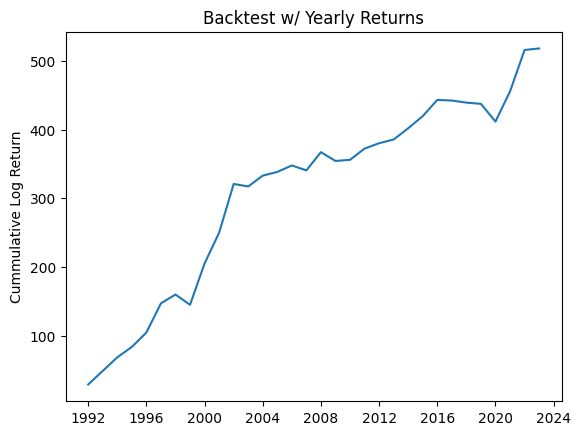

In [32]:
plt.plot(backtest_y.index,backtest_y['cum_ret'])
plt.title("Backtest w/ Yearly Returns")
plt.ylabel("Cummulative Log Return")
plt.show()

In [33]:
# Create backtest with monthly returns

backtest_m = df.groupby(['mdt','ep_bins','sg_bins'])['log_ret'].mean().unstack(level=['ep_bins','sg_bins'])

backtest_m['spread'] = backtest_m[2][0] - backtest_m[0][2]

backtest_m = backtest_m.dropna()

backtest_m = backtest_m['spread'].reset_index()

backtest_m = backtest_m.rename(columns={'spread': 'log_ret'})

backtest_m['cum_ret'] = backtest_m['log_ret'].cumsum()

backtest_m['caldt'] = pd.to_datetime(backtest_m['mdt'])

backtest_m

,mdt,log_ret,cum_ret,caldt
0,1991-05,0.002214,0.002214,1991-05-01
1,1991-06,0.030638,0.032851,1991-06-01
2,1991-07,-0.010563,0.022289,1991-07-01
3,1991-08,-0.021287,0.001001,1991-08-01
4,1991-09,-0.021212,-0.020211,1991-09-01
...,...,...,...,...
387,2023-08,0.034265,5.363403,2023-08-01
388,2023-09,0.040966,5.404369,2023-09-01
389,2023-10,0.074662,5.479031,2023-10-01
390,2023-11,-0.030193,5.448838,2023-11-01


In [34]:
bmk = yf.download('^GSPC', start=start, end=end)

bmk = bmk.reset_index()

bmk = bmk.rename(columns={'Date': 'caldt', 'Adj Close': 'prc'})

bmk = bmk[['caldt', 'prc']]

bmk['mdt'] = bmk['caldt'].dt.strftime("%Y-%m")

bmk = bmk.groupby('mdt').agg({'prc': 'first'}).reset_index()

bmk['caldt'] = pd.to_datetime(bmk['mdt'])

bmk['ret'] = bmk['prc'].pct_change()
bmk['log_ret'] = np.log(1 + bmk['ret'])
bmk['cum_ret'] = bmk['log_ret'].cumsum()

bmk

[*********************100%***********************]  1 of 1 completed


,mdt,prc,caldt,ret,log_ret,cum_ret
0,1990-04,330.799988,1990-04-01,NaN,NaN,NaN
1,1990-05,332.250000,1990-05-01,0.004383,0.004374,0.004374
2,1990-06,363.160004,1990-06-01,0.093032,0.088956,0.093330
3,1990-07,359.540009,1990-07-01,-0.009968,-0.010018,0.083312
4,1990-08,355.519989,1990-08-01,-0.011181,-0.011244,0.072068
...,...,...,...,...,...,...
410,2024-06,5283.399902,2024-06-01,0.052808,0.051461,2.770811
411,2024-07,5475.089844,2024-07-01,0.036282,0.035639,2.806450
412,2024-08,5446.680176,2024-08-01,-0.005189,-0.005202,2.801248
413,2024-09,5528.930176,2024-09-01,0.015101,0.014988,2.816236


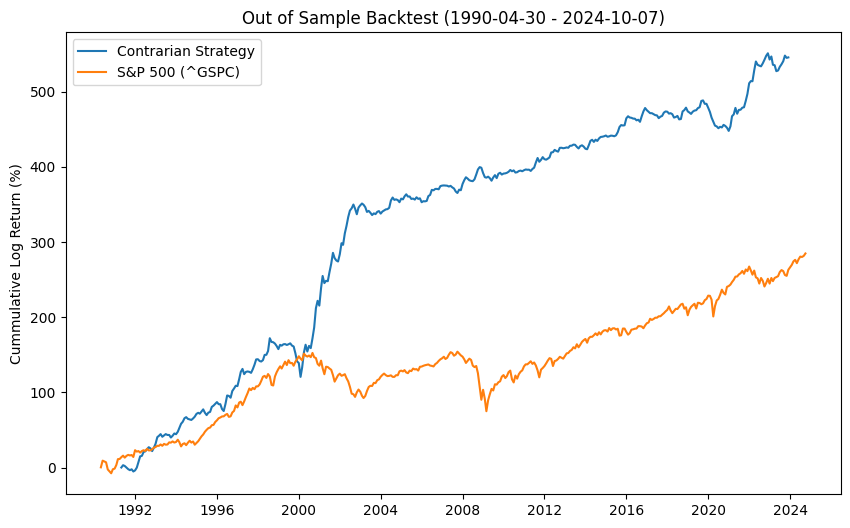

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(backtest_m['caldt'], backtest_m['cum_ret'] * 100, label='Contrarian Strategy')
plt.plot(bmk['caldt'], bmk['cum_ret'] * 100, label='S&P 500 (^GSPC)')
plt.title(f"Out of Sample Backtest ({start} - {end})")
plt.ylabel("Cummulative Log Return (%)")
plt.legend()
plt.show()

In [36]:
# Calculate sharpe ratio using monthly returns

numerator = backtest_m['log_ret'].mean()
denominator = backtest_m['log_ret'].std()
scale = 12 / np.sqrt(12)

sharpe = numerator / denominator * scale

print(f"Sharpe Ratio of {round(sharpe,2)}")

Sharpe Ratio of 0.96


### 5 Factor Model Decomposition

In [37]:
fac = pd.read_csv("~/Data/fama_5_factors.csv")

fac['mdt'] = pd.to_datetime(fac['DATE'].astype(str), format='%Y%m').dt.strftime("%Y-%m")

fac

,DATE,Mkt-RF,SMB,HML,RMW,CMA,RF,mdt
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27,1963-07
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25,1963-08
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27,1963-09
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29,1963-10
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27,1963-11
...,...,...,...,...,...,...,...,...
729,202404,-4.67,-2.56,-0.52,1.48,-0.30,0.47,2024-04
730,202405,4.34,0.76,-1.66,2.98,-3.07,0.44,2024-05
731,202406,2.77,-4.37,-3.31,0.51,-1.78,0.41,2024-06
732,202407,1.24,8.28,5.73,0.22,0.43,0.45,2024-07


In [38]:
merge = pd.merge(backtest_m, fac, on='mdt', how='inner')

merge = merge.drop(columns=['cum_ret', 'caldt', 'DATE'])

merge['log_ret'] = merge['log_ret'] * 100

merge = merge.rename(columns={'Mkt-RF': 'MKT'})

merge

,mdt,log_ret,MKT,SMB,HML,RMW,CMA,RF
0,1991-05,0.221372,3.65,0.14,-0.52,2.00,-2.43,0.47
1,1991-06,3.063763,-4.94,0.24,1.15,1.79,0.65,0.42
2,1991-07,-1.056277,4.24,-0.96,-1.32,1.60,-1.36,0.49
3,1991-08,-2.128711,2.32,1.40,-0.78,0.84,-0.34,0.46
4,1991-09,-2.121245,-1.59,1.56,-1.08,-1.82,0.08,0.46
...,...,...,...,...,...,...,...,...
387,2023-08,3.426530,-2.39,-3.68,-1.08,3.42,-2.37,0.45
388,2023-09,4.096567,-5.24,-1.79,1.45,1.85,-0.84,0.43
389,2023-10,7.466208,-3.18,-4.05,0.19,2.47,-0.67,0.47
390,2023-11,-3.019306,8.83,-0.11,1.66,-3.81,-0.99,0.44


In [39]:
model = smf.ols("log_ret ~ MKT + SMB + HML + RMW + CMA", data=merge).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ret   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     457.4
Date:                Mon, 07 Oct 2024   Prob (F-statistic):          1.00e-159
Time:                        20:10:42   Log-Likelihood:                -810.74
No. Observations:                 392   AIC:                             1633.
Df Residuals:                     386   BIC:                             1657.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1393      0.103     11.103      0.000       0.938       1.341
MKT           -0.2681      0.025    -10.712      0.000      -0.317      -0.219
SMB           -0.2109      0.037     -5.761      0.000      -0.283      -0.139
HML            0.7055      0.042     16.916      0.000       0.623       0.787
RMW            0.7022      0.046     15.262      0.000       0.612       0.793
CMA            0.3785      0.063      6.026      0.000       0.255       0.502
==============================================================================
Omnibus:                       14.888   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               33.810
Skew:                          -0.050   Prob(JB):                     4.55e-08
Kurtosis:                       4.435   Cond. No.                         5.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
model = smf.ols("log_ret ~ MKT", data=merge).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ret   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     119.8
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           1.71e-24
Time:                        20:10:42   Log-Likelihood:                -1137.5
No. Observations:                 392   AIC:                             2279.
Df Residuals:                     390   BIC:                             2287.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7928      0.226      7.930      0.000       1.348       2.237
MKT           -0.5530      0.051    -10.945      0.000      -0.652      -0.454
==============================================================================
Omnibus:                       30.354   Durbin-Watson:                   1.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.586
Skew:                           0.171   Prob(JB):                     5.88e-25
Kurtosis:                       5.591   Cond. No.                         4.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""